In [1]:
from torch.nn import functional as F
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch import optim
from torchvision import models
from torchvision import datasets
from torchvision import transforms as T

import numpy as np
import torchutils as tu
import matplotlib.pyplot as plt

import mlflow
from mlflow.models import infer_signature
from PIL import Image

In [2]:
torch.cuda.empty_cache()
use_mlflow = True
mlflow_experiment_name = 'SKIN-CANCER-CNN'

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
config = {
    'device': DEVICE,
    'batch_size': 512,
    'learning_rate': 0.001,
    'epochs': 5,
    'data_dir': '../data/',
    'log_dir': '../runs/experiment1',
    'transformations': [
        
    ]
}

DEVICE

'cuda'

In [3]:
train_transform = T.Compose([
    T.Resize((256, 256)),  
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    T.RandomRotation(degrees=15),
    T.RandomAffine(degrees=0, translate=(0.1, 0.1)),  
    T.RandomResizedCrop(size=256, scale=(0.9, 1.1)),  
    T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    T.RandomErasing(p=0.3, scale=(0.02, 0.1)),
])

valid_transforms = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
train_dataset = datasets.ImageFolder(
    config['data_dir']+ 'train',
    transform=train_transform
    )

valid_dataset = datasets.ImageFolder(
    config['data_dir']+ 'test',
    transform=valid_transforms
    )

In [5]:
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=False)

In [6]:
model = models.resnet50(weights='DEFAULT')
model.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
tu.get_model_summary(model, torch.randn(config['batch_size'], 3, 256, 256, device=DEVICE))

Layer                                         Kernel               Output           Params              FLOPs
0_conv1                                      [3, 64, 7, 7]   [512, 64, 128, 128]       9,408   78,920,024,064
1_bn1                                                 [64]   [512, 64, 128, 128]         128    2,147,483,648
2_relu                                                   -   [512, 64, 128, 128]           0                0
3_maxpool                                                -     [512, 64, 64, 64]           0                0
4_layer1.0.Conv2d_conv1                     [64, 64, 1, 1]     [512, 64, 64, 64]       4,096    8,589,934,592
5_layer1.0.BatchNorm2d_bn1                            [64]     [512, 64, 64, 64]         128      536,870,912
6_layer1.0.ReLU_relu                                     -     [512, 64, 64, 64]           0                0
7_layer1.0.Conv2d_conv2                     [64, 64, 3, 3]     [512, 64, 64, 64]      36,864   77,309,411,328
8_layer1.0

In [8]:
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(2048, 1)
model.fc.weight.requires_grad = True
model.fc.bias.requires_grad = True

model.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
optimizer = torch.optim.Adam(model.parameters(), config['learning_rate'])
criterion = torch.nn.BCEWithLogitsLoss()

In [10]:
def compute_batch_accuracy(preds, labels):
    preds_reshaped = preds.squeeze(-1)
    preds_sigmoid = preds_reshaped.sigmoid()
    preds_classes = torch.round(preds_sigmoid)
    bool_array = preds_classes == labels
    number_of_true = bool_array.sum()
    accuracy = number_of_true / len(labels)
    accuracy_float = accuracy.item()
    
    return accuracy_float

In [11]:
def fit(
        model: torch.nn.Module, 
        epochs: int, 
        optimizer: torch.optim.Optimizer,
        train_loader: DataLoader,
        valid_loader: DataLoader
        ) -> dict:
    """Function to fit model

    Returns:
        dict with:
            train_loss: list of train losses per epoch
            valid_loss: list of valid losses per epoch
            train_metric: list of train accuracy per epoch
            valid_metric: list of valid accuracy per epoch
    """
    history = {
        'train_loss': [],
        'valid_loss': [],
        'train_metric': [],
        'valid_metric': []
    }

    for epoch in range(epochs):
        model.train()
        batch_loss = []
        batch_metric = []

        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            preds = model(images)
            loss = criterion(preds.squeeze(-1), labels.float())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_loss.append(loss.item())
            batch_metric.append(compute_batch_accuracy(preds, labels))
        
        
        train_loss = np.mean(batch_loss)
        train_metric = np.mean(batch_metric)
        history['train_loss'].append(train_loss)
        history['train_metric'].append(train_metric)
        
        
        model.eval()
        batch_loss = []
        batch_metric = []
        
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                
                preds = model(images)
                loss = criterion(preds.squeeze(-1), labels.float())
                
                batch_loss.append(loss.item())
                batch_metric.append(compute_batch_accuracy(preds, labels))
                
        valid_loss = np.mean(batch_loss)
        valid_metric = np.mean(batch_metric)
        history['valid_loss'].append(valid_loss)
        history['valid_metric'].append(valid_metric)
        
        if use_mlflow:
            mlflow.log_metric('train_loss', train_loss, epoch)
            mlflow.log_metric('valid_loss', valid_loss, epoch)
            mlflow.log_metric('train_metric', train_metric, epoch)
            mlflow.log_metric('valid_metric', valid_metric, epoch)

        print(
            f'Epoch [{epoch+1} / {epochs}] : '
            f'Train Loss: {train_loss:.4f} | '
            f'Valid Loss: {valid_loss:.4f} | '
            f'Train Accuracy: {train_metric:.4f} | '
            f'Valid Accuracy: {valid_metric:.4f}'
        )
    
    return history

In [12]:
if use_mlflow:
    mlflow.set_experiment(mlflow_experiment_name)
    with mlflow.start_run(
        run_name=f'SKINCARE_RESNET50_bs_{config['batch_size']}_lr_{config['learning_rate']}'
    ):
        mlflow.log_params(config)
        logs = fit(model, config['epochs'], optimizer, train_loader, valid_loader)
        mlflow.pytorch.log_model(
            model,
            'model',
            )
else:
    logs = fit(model, config['epochs'], optimizer, train_loader, valid_loader)

Epoch [1 / 5] : Train Loss: 0.6629 | Valid Loss: 0.7646 | Train Accuracy: 0.5542 | Valid Accuracy: 0.3549
Epoch [2 / 5] : Train Loss: 0.6080 | Valid Loss: 0.6687 | Train Accuracy: 0.6134 | Valid Accuracy: 0.5179
Epoch [3 / 5] : Train Loss: 0.5558 | Valid Loss: 0.5810 | Train Accuracy: 0.7818 | Valid Accuracy: 0.7802
Epoch [4 / 5] : Train Loss: 0.5213 | Valid Loss: 0.5350 | Train Accuracy: 0.8069 | Valid Accuracy: 0.8299
Epoch [5 / 5] : Train Loss: 0.4953 | Valid Loss: 0.4995 | Train Accuracy: 0.8195 | Valid Accuracy: 0.8556


2025/05/30 16:16:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [13]:
#torch.save(model.state_dict(), 'model2.pt')

In [14]:
img, true_label = next(iter(valid_loader))

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

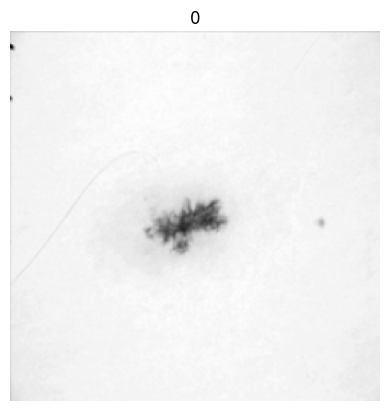

In [15]:
plt.imshow(img[0][0], cmap='gray')
plt.title(f'{true_label[0]}'); plt.axis('off')

In [16]:
img[0].unsqueeze(0).shape

torch.Size([1, 3, 256, 256])

In [17]:
with torch.inference_mode():
    pred_class = model(img[0].unsqueeze(0).to(DEVICE)).softmax(dim=1).argmax().item()

print(f'pred class: {pred_class}')

pred class: 0


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

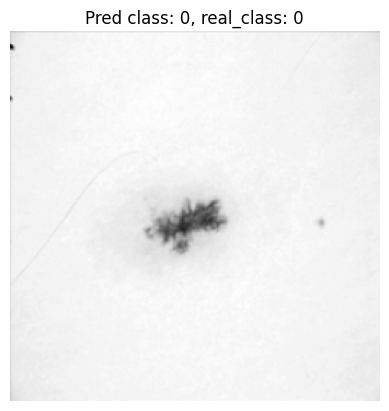

In [18]:
plt.imshow(img[0][0], cmap='gray')
plt.title(f'Pred class: {pred_class}, real_class: {true_label[0]}')
plt.axis('off')